## Milk Dataset

In [149]:
import pandas as pd
milk = pd.read_csv('../Datasets/milk.csv', index_col=0)
# milk

### Standard Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas')
scaled_data = scaler.fit_transform(milk)
scaled_data.head()

,water,protein,fat,lactose,ash
Animal,,,,,
HORSE,0.948806,-1.009291,-0.903208,1.542217,-1.037554
ORANGUTAN,0.821407,-1.344603,-0.660619,1.040773,-1.259945
MONKEY,0.813445,-1.121062,-0.738247,1.263637,-1.381249
DONKEY,0.964731,-1.260775,-0.864394,1.152205,-0.936467
HIPPO,0.972694,-1.568145,-0.563583,0.149319,-1.542988


### Principle Compoment

In [18]:
from sklearn.decomposition import PCA
pr_comp = PCA().set_output(transform='pandas')
pca_data = pr_comp.fit_transform(scaled_data)
pca_data.shape

(25, 5)

In [28]:
# pr_comp.get_params()

### Variance explained by each of the components

In [22]:
pca_data.var()

pca0    4.040412
pca1    0.924372
pca2    0.134291
pca3    0.102689
pca4    0.006570
dtype: float64

In [23]:
pca_data.var().sum()

5.208333333333337

In [24]:
pca_data.var() / pca_data.var().sum() # Proportions

pca0    0.775759
pca1    0.177479
pca2    0.025784
pca3    0.019716
pca4    0.001261
dtype: float64

In [25]:
pca_data.var() / pca_data.var().sum() * 100 # Percentages

pca0    77.575905
pca1    17.747950
pca2     2.578385
pca3     1.971621
pca4     0.126140
dtype: float64

### Using attributes

In [31]:
pr_comp.explained_variance_

array([4.0404117 , 0.92437238, 0.13429088, 0.1026886 , 0.00656977])

In [32]:
pr_comp.explained_variance_ratio_

array([0.77575905, 0.1774795 , 0.02578385, 0.01971621, 0.0012614 ])

In [33]:
pr_comp.explained_variance_ratio_*100

array([77.57590469, 17.74794969,  2.57838496,  1.97162103,  0.12613963])

## HR Data

In [81]:
hr = pd.read_csv('../Cases/human-resources-analytics/HR_comma_sep.csv')
X, y = hr.drop('left', axis=1), hr['left']

### Train Test Split

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

### One Hot Encoding

In [83]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')
ct = make_column_transformer(
    (ohe, make_column_selector(dtype_include=object)),
    ('passthrough', make_column_selector(dtype_exclude=object)),
    verbose_feature_names_out=False
).set_output(transform='pandas')
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

### Standard Scaling

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### PCA Transformation

In [85]:
from sklearn.decomposition import PCA
prcomp = PCA().set_output(transform='pandas')
pca_data = prcomp.fit_transform(X_train)
pca_data.shape

(10496, 18)

In [62]:
import numpy as np
np.cumsum(prcomp.explained_variance_ratio_*100)

array([ 10.44330023,  20.68450468,  28.02067385,  34.79635877,
        41.446328  ,  47.8475919 ,  53.95312559,  59.88279839,
        65.76386736,  71.62362546,  77.36628748,  82.74524721,
        87.61399927,  92.18260673,  95.68051043,  98.67935511,
        99.46027765, 100.        ])

### Ploting the Principle Components

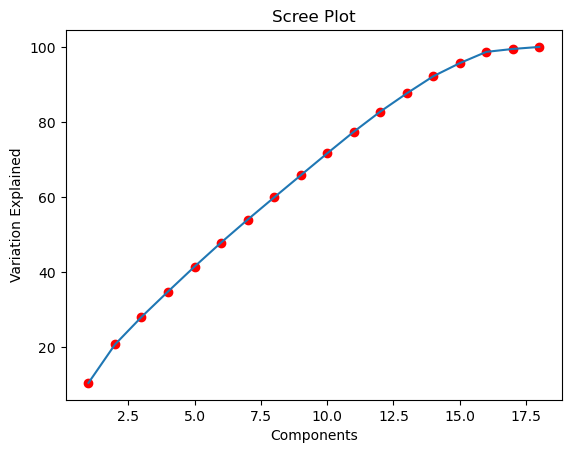

In [63]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(1, prcomp.n_components_+1), np.cumsum(prcomp.explained_variance_ratio_*100), c="red")
plt.plot(np.arange(1, prcomp.n_components_+1), np.cumsum(prcomp.explained_variance_ratio_*100))
plt.title("Scree Plot")
plt.xlabel("Components")
plt.ylabel("Variation Explained")
plt.show()

### Selecting Top Principle Components

In [64]:
selected_trn_pca = pca_data.iloc[:, :14] # Selecting top 14 components

### Building model on the PC

In [65]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(selected_trn_pca, y_train)

LogisticRegression()

In [77]:
### Transforming the Test data
X_test = scaler.transform(X_test)
X_tst_pca = prcomp.transform(X_test)
selected_tst_pca = X_tst_pca.iloc[:, :14]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [79]:
from sklearn.metrics import accuracy_score
y_pred = lr.predict(selected_tst_pca)
accuracy_score(y_test, y_pred)

0.25827961769282065

### Pipeling the process

In [90]:
ohe = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')
ct_ohe = make_column_transformer(
    (ohe, make_column_selector(dtype_include=object)),
    ('passthrough', make_column_selector(dtype_exclude=object)),
    verbose_feature_names_out=False
).set_output(transform='pandas')

scaler = StandardScaler()

lr = LogisticRegression()

prcomp = PCA().set_output(transform='pandas')

from sklearn.pipeline import Pipeline
pipe = Pipeline(
    [
        ('OHE', ct_ohe),
        ('SCL', scaler),
        ('PCA', prcomp),
        ('LR', lr)
    ]
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.793731940431207

In [92]:
pipe.get_params()

{'memory': None,
 'steps': [('OHE',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(drop='first',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000021E4EF3CBC0>),
                                   ('passthrough', 'passthrough',
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000021E4EF3D310>)],
                     verbose_feature_names_out=False)),
  ('SCL', StandardScaler()),
  ('PCA', PCA()),
  ('LR', LogisticRegression())],
 'verbose': False,
 'OHE': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000021

In [112]:
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
params = {'PCA__n_components': np.arange(10, 17), 
         'LR__C': [0.0001, 0.001, 0.01, 0.5, 1, 1.5, 2.5]}
kfold = KFold(n_splits=5, shuffle=True, random_state=24)

gcv_lr = GridSearchCV(pipe, param_grid=params, cv=kfold, scoring='accuracy')

In [113]:
gcv_lr

GridSearchCV(cv=KFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('OHE',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000021E4EF3CBC0>),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000021E4EF3D310>)],
                                                          verbose_feature_names_out=False)),
                                       ('SCL', StandardScaler()),
                                       ('PCA', PCA()),
                                       ('LR', LogisticRegression())]),
             param_grid={'LR__C': [0.0001, 0.001, 0.01, 0.5, 1, 1.5, 2.5],
                         'PCA__n_components': array([10, 11, 12, 13, 14, 15, 16])},
             scoring='accuracy')

In [114]:
import warnings
warnings.filterwarnings('ignore')
gcv_lr.fit(X_train, y_train)
y_pred = gcv_lr.predict(X_test)

In [115]:
print(gcv_lr.best_params_)
print(gcv_lr.best_score_)

{'LR__C': 0.001, 'PCA__n_components': 13}
0.7852521155198621


## Company Bankruptcy

In [117]:
df = pd.read_csv('../Cases/Company Bankruptcy/data.csv')
# df.head()
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [119]:
df.isna().sum().sum()

0

In [125]:
X, y = df.drop(columns=['Bankrupt?']), df['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24, stratify=y)

In [126]:
scaler = StandardScaler()
lr = LogisticRegression()
prcomp = PCA().set_output(transform='pandas')

pipe = Pipeline(
    [
        ('SCL', scaler),
        ('PCA', prcomp),
        ('LR', lr)
    ]
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.9643206256109482

In [137]:
params = {'PCA__n_components': np.arange(30,65), 
         'LR__C': [0.001, 0.01, 0.5, 1]}
kfold = KFold(n_splits=5, shuffle=True, random_state=24)

gcv_lr = GridSearchCV(pipe, param_grid=params, cv=kfold, scoring='f1')

In [138]:
gcv_lr.fit(X_train, y_train)
y_pred = gcv_lr.predict(X_test)
print(gcv_lr.best_params_)
print(gcv_lr.best_score_)

{'LR__C': 0.5, 'PCA__n_components': 54}
0.3010839160839161


In [142]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
comps =[32,48,40,54,62]
scores = []

for i in comps:
    lr = LogisticRegression()
    scl_min  =  MinMaxScaler().set_output(transform='pandas')
    pca = PCA(n_components = i).set_output(transform='pandas')
    pipe = Pipeline([ ('SCL', scl_min) , ('PCA', pca) , ('LR', lr)])
    pipe.fit(X_train , y_train)
    y_pred = pipe.predict(X_test)
    scores.append(f1_score(y_test , y_pred , pos_label=1))

In [144]:
np.max(scores)

0.0547945205479452

In [146]:
comps[np.argmax(scores)]

32

## Kernel PCA

In [151]:
import pandas as pd
milk = pd.read_csv('../Datasets/milk.csv', index_col=0)
# milk

In [152]:
# Standard Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas')
scaled_data = scaler.fit_transform(milk)
scaled_data.head()

,water,protein,fat,lactose,ash
Animal,,,,,
HORSE,0.948806,-1.009291,-0.903208,1.542217,-1.037554
ORANGUTAN,0.821407,-1.344603,-0.660619,1.040773,-1.259945
MONKEY,0.813445,-1.121062,-0.738247,1.263637,-1.381249
DONKEY,0.964731,-1.260775,-0.864394,1.152205,-0.936467
HIPPO,0.972694,-1.568145,-0.563583,0.149319,-1.542988


In [155]:
from sklearn.decomposition import KernelPCA
pr_comp = KernelPCA(kernel='linear').set_output(transform='pandas')
pca_data = pr_comp.fit_transform(scaled_data)
pca_data.shape

(25, 5)